In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
import ast
from statistics import mean, median, stdev
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Load your dataset
# Replace 'your_data.csv' with the path to your dataset
merged_df = pd.read_csv('merged_classifier_data.csv')

In [48]:
# Rename the columns to the new names
merged_df.rename(columns={
    'Top 100 Detections (Avg Confidence, Length)': 'Top_Detections_AvgConfidence_SequenceCount',
    'Top 100 Confidences (Avg Confidence, Length)': 'Top_Confidences_AvgScore_SequenceCount'
}, inplace=True)

# Confirm the new column names
merged_df.columns.tolist()

['Video Index',
 'Detections',
 'Processing Time (seconds)',
 'Density of Detections',
 'Top_Detections_AvgConfidence_SequenceCount',
 'Top_Confidences_AvgScore_SequenceCount',
 'Label']

In [49]:
# Function to parse the string representation of lists into actual list of tuples
def parse_list_of_tuples(data_str):
    try:
        return ast.literal_eval(data_str)
    except (ValueError, SyntaxError):
        return []

# Apply the parsing function to the relevant columns
merged_df['Top_Detections_AvgConfidence_SequenceCount'] = merged_df['Top_Detections_AvgConfidence_SequenceCount'].apply(parse_list_of_tuples)
merged_df['Top_Confidences_AvgScore_SequenceCount'] = merged_df['Top_Confidences_AvgScore_SequenceCount'].apply(parse_list_of_tuples)

In [50]:
from statistics import mean, median, stdev

# Function to calculate statistics for the confidence values
def calculate_confidence_stats(confidence_list):
    confidences = [x[0] for x in confidence_list if isinstance(x, tuple) and len(x) == 2]
    return {
        'mean': mean(confidences) if confidences else None,
        'median': median(confidences) if confidences else None,
        'std': stdev(confidences) if len(confidences) > 1 else None
    }

# Function to calculate statistics for the sequence count
def calculate_sequence_count_stats(sequence_list):
    sequences = [x[1] for x in sequence_list if isinstance(x, tuple) and len(x) == 2]
    return {
        'mean': mean(sequences) if sequences else None,
        'median': median(sequences) if sequences else None,
        'std': stdev(sequences) if len(sequences) > 1 else None
    }

# Apply the functions to calculate the statistics for Top_Detections
detection_stats = merged_df['Top_Detections_AvgConfidence_SequenceCount'].apply(calculate_confidence_stats)
sequence_count_stats = merged_df['Top_Detections_AvgConfidence_SequenceCount'].apply(calculate_sequence_count_stats)

# Apply the functions to calculate the statistics for Top_Confidences
confidence_stats = merged_df['Top_Confidences_AvgScore_SequenceCount'].apply(calculate_confidence_stats)
conf_sequence_count_stats = merged_df['Top_Confidences_AvgScore_SequenceCount'].apply(calculate_sequence_count_stats)

# Add the statistics as new columns to the DataFrame
merged_df['Det_Confidence_Mean'] = detection_stats.apply(lambda x: x['mean'])
merged_df['Det_Confidence_Median'] = detection_stats.apply(lambda x: x['median'])
merged_df['Det_Confidence_Std'] = detection_stats.apply(lambda x: x['std'])
merged_df['Det_SequenceCount_Mean'] = sequence_count_stats.apply(lambda x: x['mean'])
merged_df['Det_SequenceCount_Median'] = sequence_count_stats.apply(lambda x: x['median'])
merged_df['Det_SequenceCount_Std'] = sequence_count_stats.apply(lambda x: x['std'])

merged_df['Conf_Confidence_Mean'] = confidence_stats.apply(lambda x: x['mean'])
merged_df['Conf_Confidence_Median'] = confidence_stats.apply(lambda x: x['median'])
merged_df['Conf_Confidence_Std'] = confidence_stats.apply(lambda x: x['std'])
merged_df['Conf_SequenceCount_Mean'] = conf_sequence_count_stats.apply(lambda x: x['mean'])
merged_df['Conf_SequenceCount_Median'] = conf_sequence_count_stats.apply(lambda x: x['median'])
merged_df['Conf_SequenceCount_Std'] = conf_sequence_count_stats.apply(lambda x: x['std'])

In [51]:
merged_df

,Video Index,Detections,Processing Time (seconds),Density of Detections,Top_Detections_AvgConfidence_SequenceCount,Top_Confidences_AvgScore_SequenceCount,Label,Det_Confidence_Mean,Det_Confidence_Median,Det_Confidence_Std,Det_SequenceCount_Mean,Det_SequenceCount_Median,Det_SequenceCount_Std,Conf_Confidence_Mean,Conf_Confidence_Median,Conf_Confidence_Std,Conf_SequenceCount_Mean,Conf_SequenceCount_Median,Conf_SequenceCount_Std
0,0136-OP-01.mp4,69,477.876334,0.144389,"[(0.51, 4), (0.59, 3), (0.5633333333333334, 3)...","[(0.8, 1), (0.785, 2), (0.735, 2), (0.72, 1), ...",NSR,0.509290,0.510000,0.138088,1.277778,1.0,0.656367,0.509290,0.510000,0.138088,1.277778,1.0,0.656367
1,0136-OP.mp4,176,544.610254,0.323167,"[(0.49549999999999994, 13), (0.654999999999999...","[(0.88, 1), (0.87, 1), (0.8225, 4), (0.82, 1),...",NSR,0.493381,0.466667,0.146585,1.670000,1.0,1.682080,0.493881,0.466667,0.146003,1.670000,1.0,1.682080
2,0136-OP-04.mp4,0,2.343351,0.000000,[],[],NSR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0136-OP-03.mp4,115,338.983108,0.339250,"[(0.5890909090909091, 11), (0.38, 4), (0.41666...","[(0.81, 1), (0.79, 1), (0.77, 1), (0.77, 1), (...",NSR,0.455215,0.405000,0.132172,1.382716,1.0,1.240644,0.455215,0.405000,0.132172,1.382716,1.0,1.240644
4,0136-OP-02.mp4,73,512.856055,0.142340,"[(0.45333333333333337, 3), (0.4766666666666666...","[(0.89, 1), (0.85, 1), (0.82, 1), (0.81, 1), (...",NSR,0.493413,0.450000,0.152051,1.158730,1.0,0.447443,0.493413,0.450000,0.152051,1.158730,1.0,0.447443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0032-01.mp4,372,316.508549,1.175324,"[(0.6689999999999999, 9), (0.5563636363636363,...","[(0.88, 1), (0.8766666666666666, 3), (0.86, 1)...",SR,0.480308,0.461250,0.122015,2.370000,2.0,1.580532,0.584333,0.560000,0.106381,1.990000,1.0,1.604885
400,0032-02.mp4,709,355.743834,1.993007,"[(0.5933333333333332, 20), (0.5944444444444444...","[(0.89, 1), (0.88, 1), (0.84, 1), (0.83, 1), (...",SR,0.520477,0.515000,0.091609,3.340000,3.0,2.383529,0.679567,0.660000,0.071342,1.470000,1.0,0.979126
401,0032-03.mp4,429,325.918704,1.316279,"[(0.5825, 8), (0.585, 8), (0.6900000000000001,...","[(0.92, 1), (0.9, 1), (0.86, 1), (0.86, 1), (0...",SR,0.507267,0.485000,0.135592,1.900000,2.0,1.210226,0.679650,0.662500,0.087745,1.510000,1.0,1.184879
402,0005-01.mp4,22,282.279780,0.077937,"[(0.4266666666666666, 3), (0.37, 1), (0.4, 1),...","[(0.7, 1), (0.57, 1), (0.53, 1), (0.52, 1), (0...",SR,0.417333,0.395000,0.100865,1.100000,1.0,0.447214,0.417333,0.395000,0.100865,1.100000,1.0,0.447214


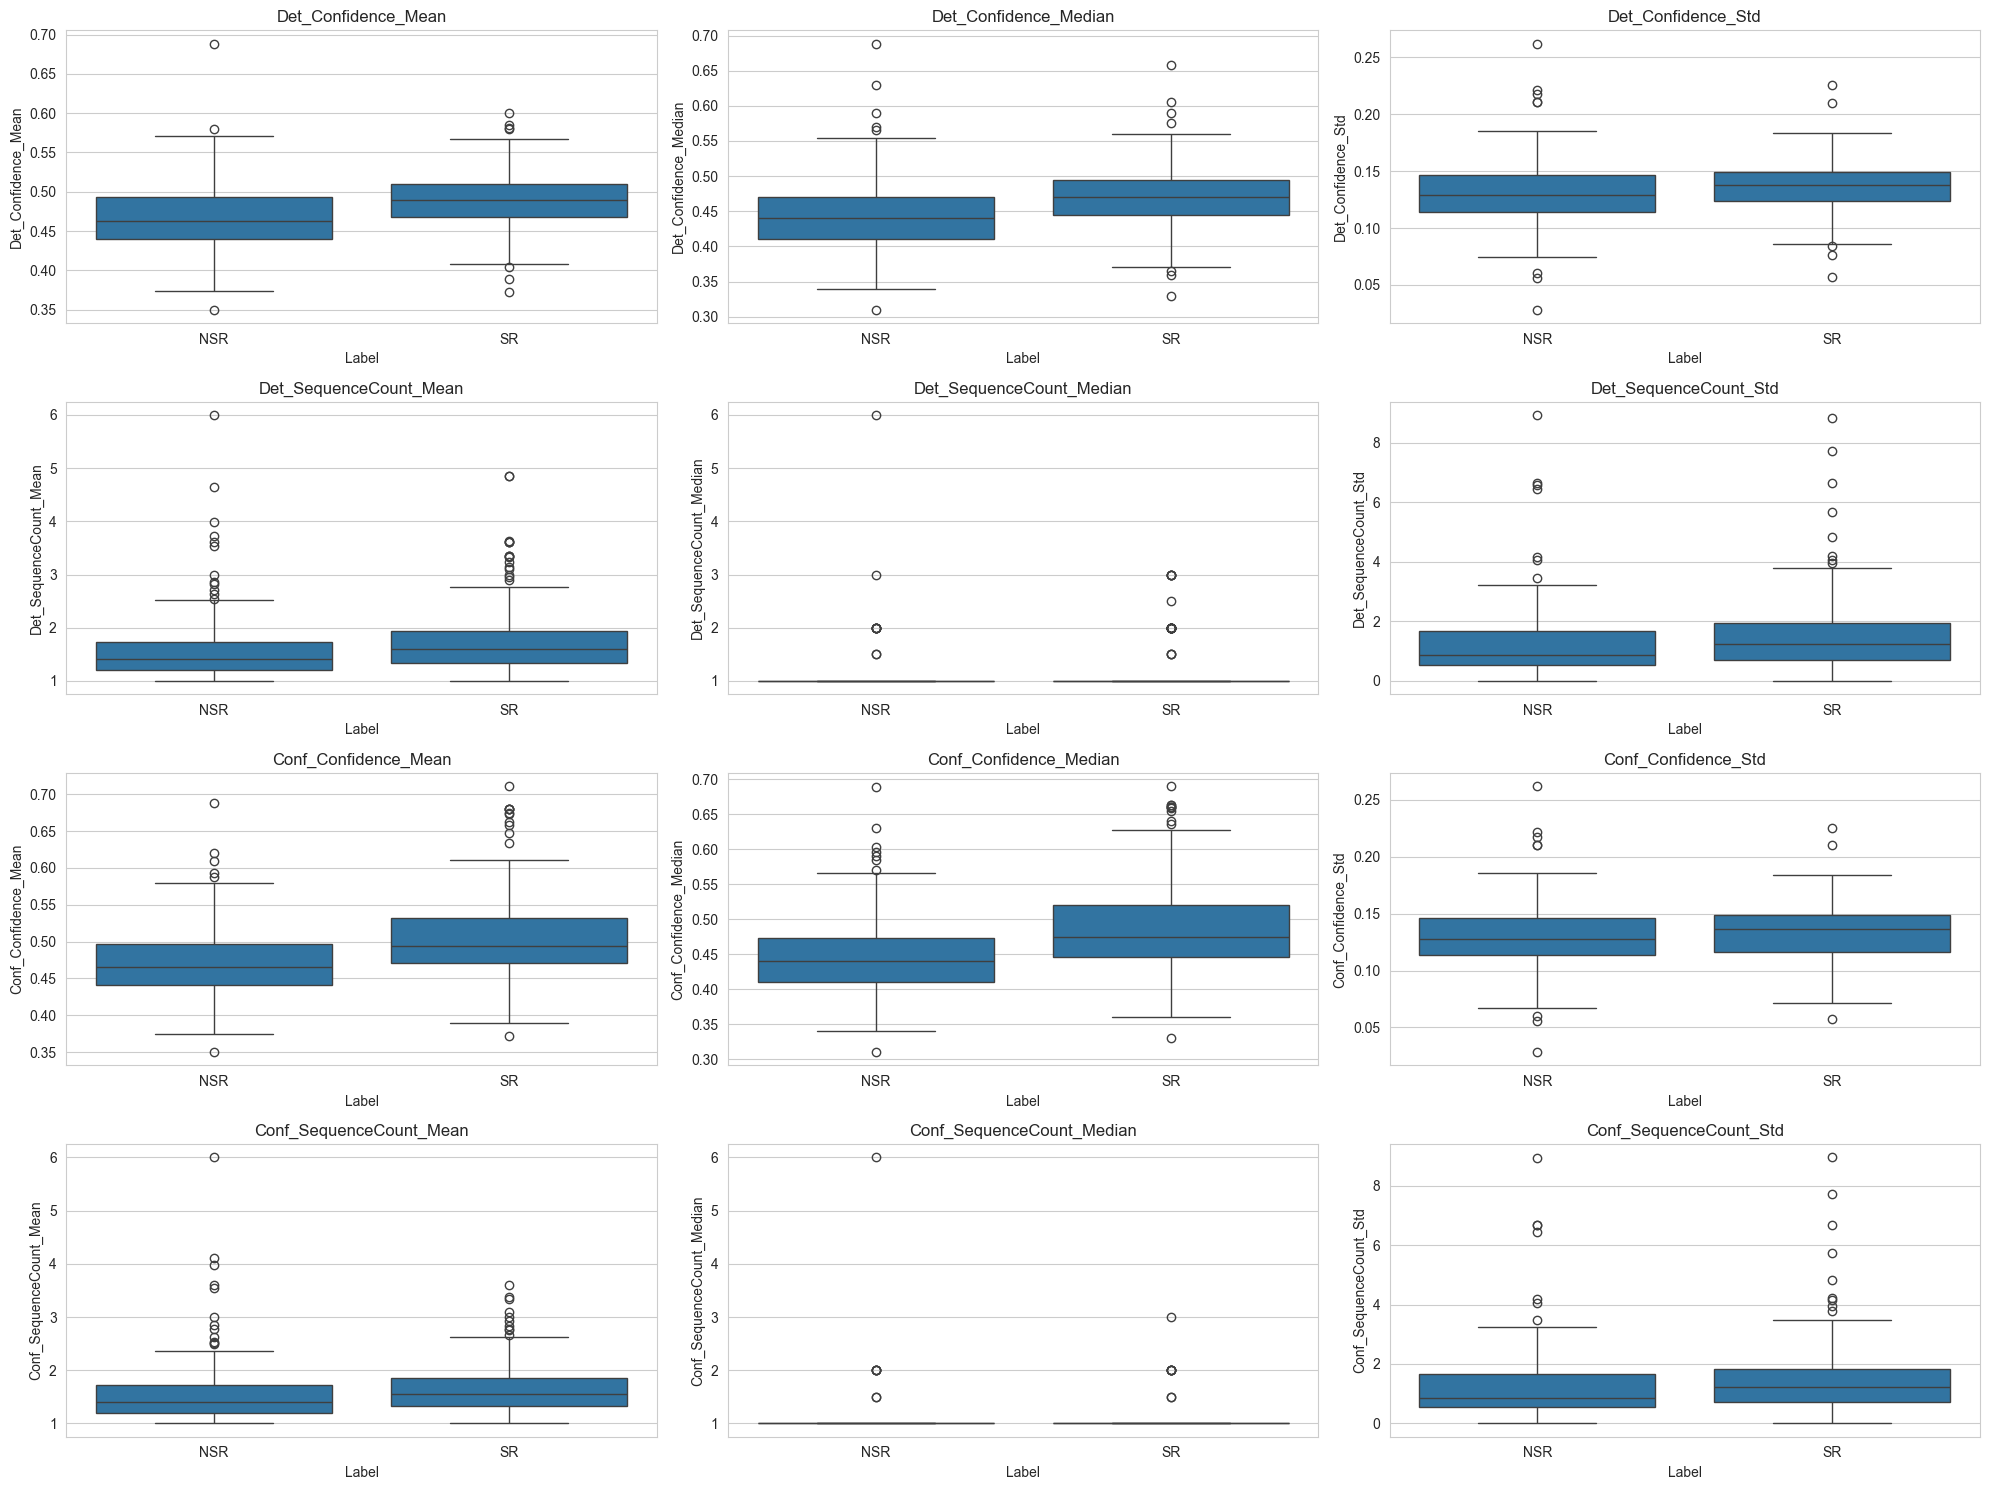

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Prepare the figure
plt.figure(figsize=(20, 15))

# List of statistics to plot
stat_columns = ['Det_Confidence_Mean', 'Det_Confidence_Median', 'Det_Confidence_Std',
                'Det_SequenceCount_Mean', 'Det_SequenceCount_Median', 'Det_SequenceCount_Std',
                'Conf_Confidence_Mean', 'Conf_Confidence_Median', 'Conf_Confidence_Std',
                'Conf_SequenceCount_Mean', 'Conf_SequenceCount_Median', 'Conf_SequenceCount_Std']

# Create a boxplot for each statistic
for i, column in enumerate(stat_columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='Label', y=column, data=merged_df)
    plt.title(column)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [56]:
# Confirm the new column names
merged_df.columns.tolist()

['Video Index',
 'Detections',
 'Processing Time (seconds)',
 'Density of Detections',
 'Top_Detections_AvgConfidence_SequenceCount',
 'Top_Confidences_AvgScore_SequenceCount',
 'Label',
 'Det_Confidence_Mean',
 'Det_Confidence_Median',
 'Det_Confidence_Std',
 'Det_SequenceCount_Mean',
 'Det_SequenceCount_Median',
 'Det_SequenceCount_Std',
 'Conf_Confidence_Mean',
 'Conf_Confidence_Median',
 'Conf_Confidence_Std',
 'Conf_SequenceCount_Mean',
 'Conf_SequenceCount_Median',
 'Conf_SequenceCount_Std']

In [312]:
# Prepare the feature dataframe (excluding non-feature columns and the target variable)
feature_columns = [
    'Detections',
    # 'Processing Time (seconds)',
    'Density of Detections',
    # 'Det_Confidence_Mean',
    # 'Det_Confidence_Median',
    # 'Det_Confidence_Std',
    # 'Det_SequenceCount_Mean',
    # 'Det_SequenceCount_Median',
    # 'Det_SequenceCount_Std',
    # 'Conf_Confidence_Mean',
    # 'Conf_Confidence_Median',
    # 'Conf_Confidence_Std',
    # 'Conf_SequenceCount_Mean',
    # 'Conf_SequenceCount_Median',
    # 'Conf_SequenceCount_Std'
]

X = merged_df[feature_columns]
y = merged_df['Label'].apply(lambda x: 1 if x == 'SR' else 0)  # Convert labels to binary

In [313]:
# Check for missing values in each column
missing_values = X.isnull().sum()

# Print the number of missing values for each column
print(missing_values)

# Visualize the distribution of the features with missing values
features_with_missing_values = missing_values[missing_values > 0].index.tolist()

for feature in features_with_missing_values:
    plt.figure(figsize=(10, 6))
    sns.histplot(X[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

Detections               0
Density of Detections    0
dtype: int64


In [314]:
# Existing columns in X
existing_columns = X.columns.tolist()

# Define columns that do not need imputation and check if they exist in X
no_impute_features = [col for col in ['Detections', 'Processing Time (seconds)', 'Density of Detections'] if col in existing_columns]

# Features believed to be normally distributed
normal_dist_features = [col for col in ['Det_Confidence_Mean', 'Det_Confidence_Median', 'Det_Confidence_Std', 
                                        'Conf_Confidence_Mean', 'Conf_Confidence_Median', 'Conf_Confidence_Std'] 
                        if col in existing_columns]

# Features believed to be right skewed
right_skewed_features = [col for col in ['Det_SequenceCount_Mean', 'Det_SequenceCount_Median', 'Det_SequenceCount_Std',
                                         'Conf_SequenceCount_Mean', 'Conf_SequenceCount_Median', 'Conf_SequenceCount_Std']
                         if col in existing_columns]

# Create the preprocessing pipelines for both types of data
preprocessor = ColumnTransformer(
    transformers=[
        ('no_impute', 'passthrough', no_impute_features),
        ('norm', SimpleImputer(strategy='mean'), normal_dist_features),
        ('skew', SimpleImputer(strategy='median'), right_skewed_features)
    ],
    remainder='drop'  # This will drop all other columns not specified in the transformer
)

# Apply the preprocessing to the X data
X_imputed = preprocessor.fit_transform(X)

# If you want to keep track of which columns were imputed and which were passed through,
# you can reconstruct the dataframe like so:

# Get feature names after transformation
transformed_columns = no_impute_features + normal_dist_features + right_skewed_features

# Create a new dataframe with the imputed and untouched values
X_transformed = pd.DataFrame(X_imputed, columns=transformed_columns)

# Show the dataframe
print(X_transformed.head())

   Detections  Density of Detections
0        69.0               0.144389
1       176.0               0.323167
2         0.0               0.000000
3       115.0               0.339250
4        73.0               0.142340


In [315]:
X_imputed = X_transformed
X_imputed

,Detections,Density of Detections
0,69.0,0.144389
1,176.0,0.323167
2,0.0,0.000000
3,115.0,0.339250
4,73.0,0.142340
...,...,...
399,372.0,1.175324
400,709.0,1.993007
401,429.0,1.316279
402,22.0,0.077937


In [316]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize classifiers
logistic_clf = LogisticRegression(random_state=42)
svm_clf = SVC(kernel='linear', random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
et_clf = ExtraTreesClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42)
lgbm_clf = lgb.LGBMClassifier(random_state=42, verbose=-1)
dt_clf = DecisionTreeClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)
# gnb_clf = GaussianNB()
mlp_clf = MLPClassifier(random_state=42)

# List of classifiers
classifiers = {
    'Logistic Regression': logistic_clf,
    'Support Vector Machine': svm_clf,
    'Random Forest': rf_clf,
    'Extra Trees': et_clf,
    'XGBoost': xgb_clf,
    'LightGBM': lgbm_clf,
    'Decision Tree': dt_clf,
    'Gradient Boosting': gb_clf,
    # 'Gaussian Naive Bayes': gnb_clf,
    'Multilayer Perceptron': mlp_clf
}

# Function to get feature importances
def get_feature_importance(clf, X, y, feature_names):
    clf.fit(X, y)
    
    if hasattr(clf, 'coef_'):
        # For Logistic Regression and SVM
        importances = clf.coef_[0]
    elif hasattr(clf, 'feature_importances_'):
        # For tree-based models
        importances = clf.feature_importances_
    else:
        # For models without feature_importance or coef_ attribute
        importances = [None] * len(feature_names)
    
    return importances

# Since some classifiers do not have feature importances, we will handle them separately
def get_ann_feature_importance(model, X, y):
    # Train the ANN model
    model.fit(X, y)
    
    # Weights of the first layer can be considered as feature importance
    # Here, we take the absolute values to consider the magnitude of weights
    # We then average the importance across all neurons in the first layer
    importance = np.mean(np.abs(model.coefs_[0]), axis=1)
    return importance

# Feature names should match the columns used for training after imputation
feature_names = feature_columns

# Dictionary to hold feature importances
feature_importances_dict = {}

# Update to include ANN feature importances if the model is an MLPClassifier
for name, clf in classifiers.items():
    if name == 'Multilayer Perceptron':
        importances = get_ann_feature_importance(clf, X_train, y_train)
    else:
        importances = get_feature_importance(clf, X_train, y_train, feature_names)
    feature_importances_dict[name] = importances

# Convert the feature importances into a DataFrame
importance_df = pd.DataFrame(feature_importances_dict, index=feature_names)

# Normalize the importances for comparability
importance_df_normalized = importance_df.div(importance_df.sum(axis=0), axis=1)

# Print the DataFrame
print(importance_df_normalized)

                       Logistic Regression  Support Vector Machine  \
Detections                        1.383423                1.219987   
Density of Detections            -0.383423               -0.219987   

                       Random Forest  Extra Trees   XGBoost  LightGBM  \
Detections                  0.470931     0.487994  0.548748  0.489102   
Density of Detections       0.529069     0.512006  0.451252  0.510898   

                       Decision Tree  Gradient Boosting  Multilayer Perceptron  
Detections                  0.437997           0.463793               0.518766  
Density of Detections       0.562003           0.536207               0.481234  


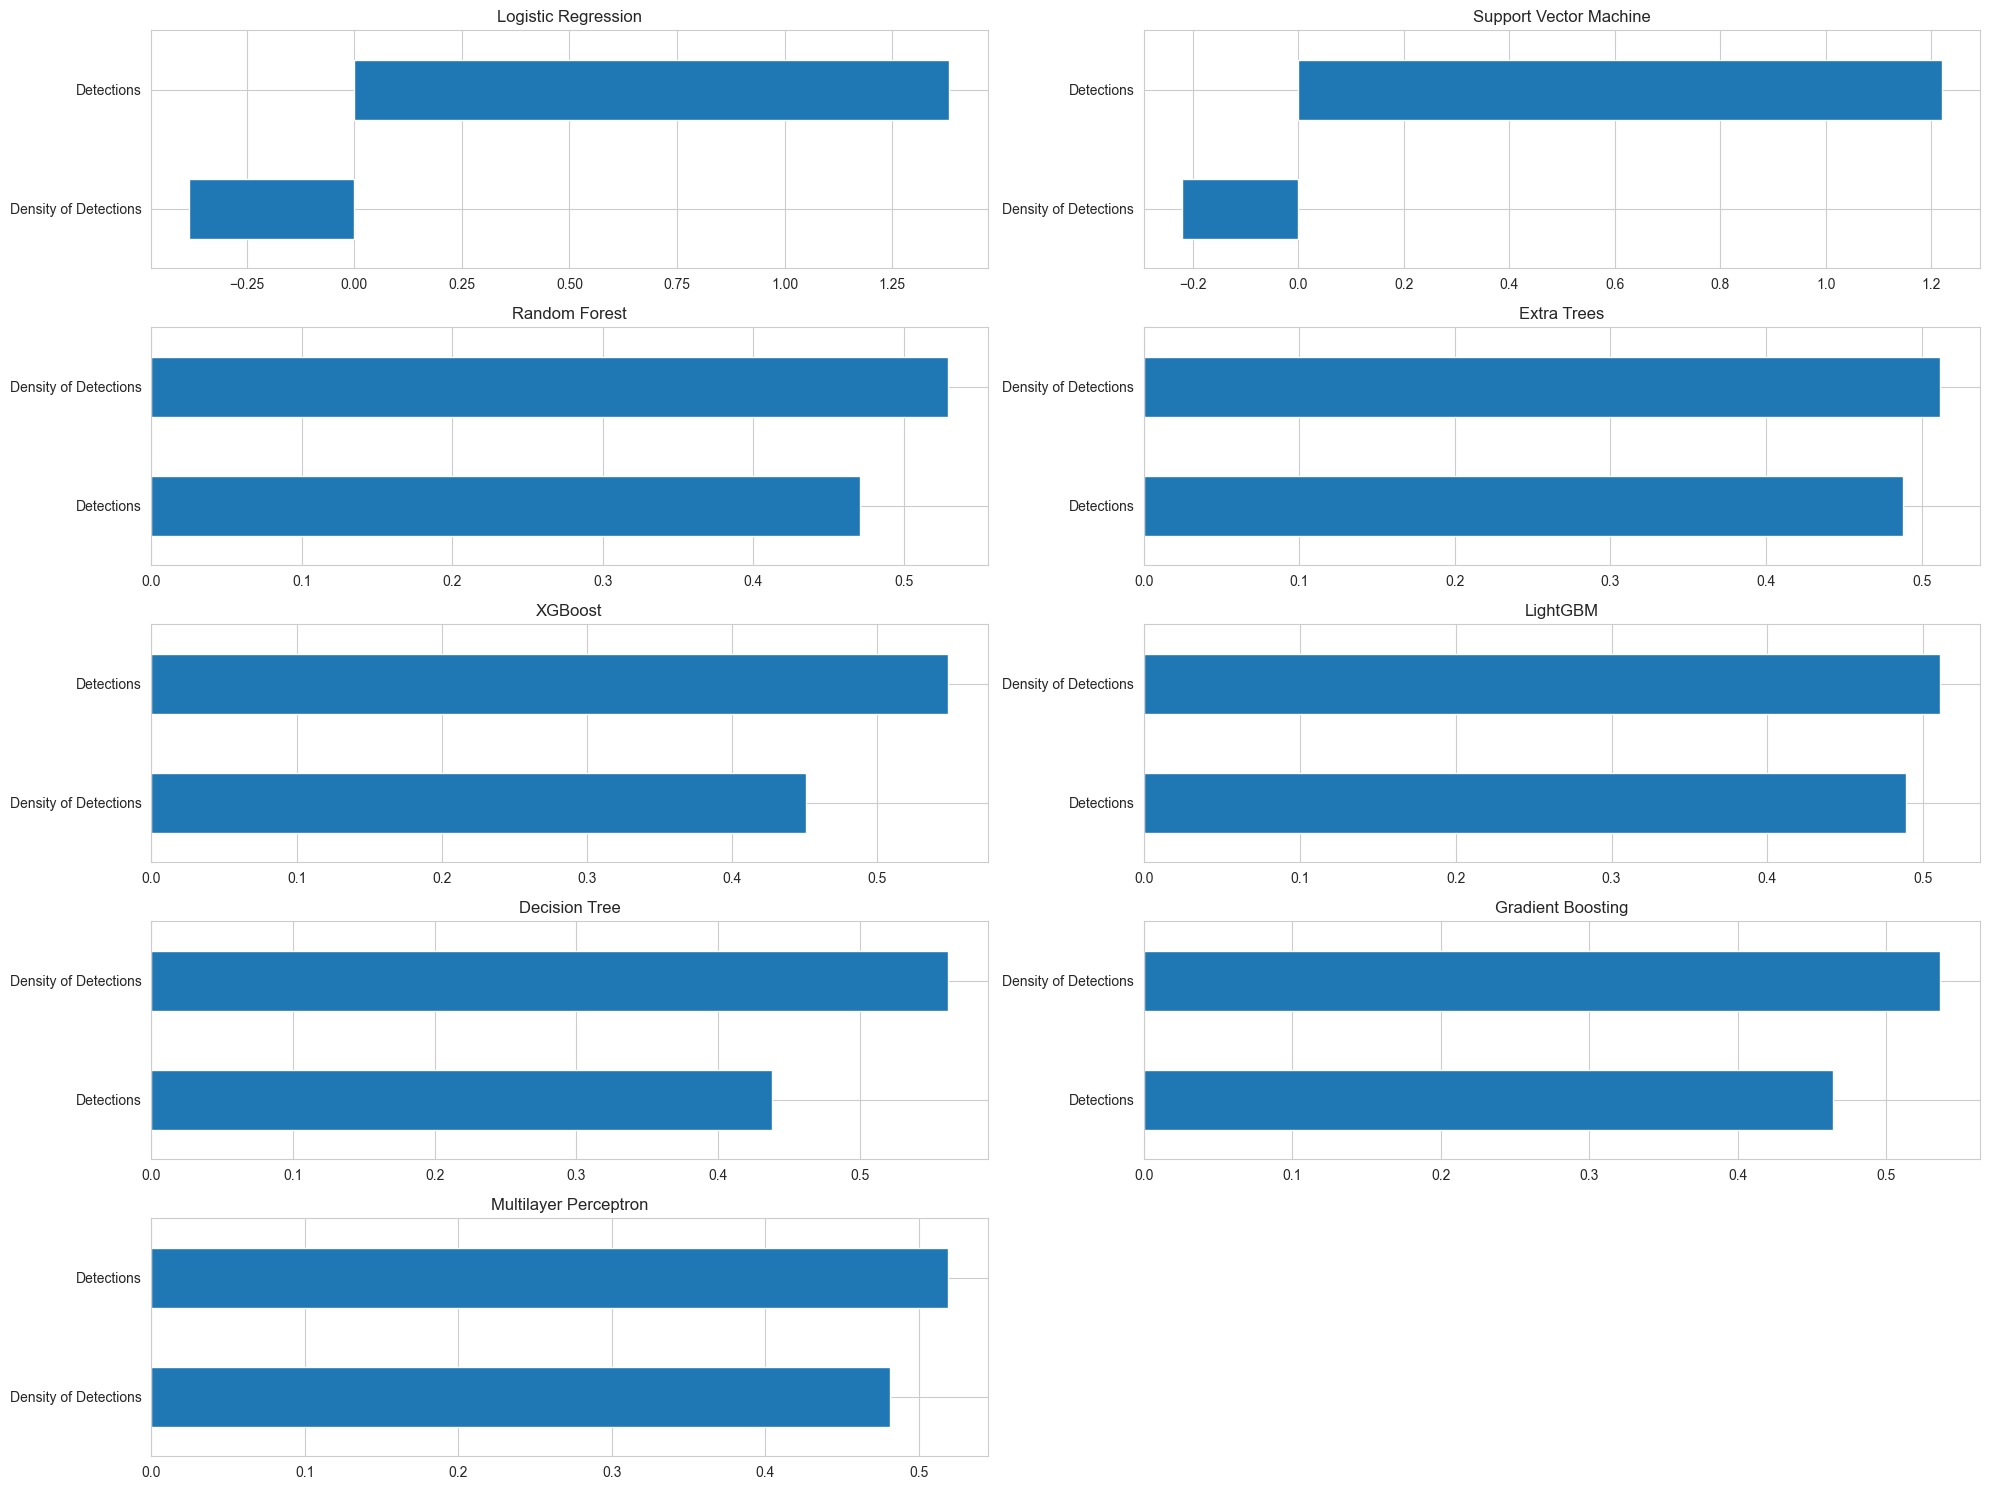

In [317]:
import matplotlib.pyplot as plt

# Assuming `importance_df_normalized` is a DataFrame like the one you've shown above,
# where the columns are classifiers and the rows are features.

# Plotting feature importances
n_classifiers = len(importance_df_normalized.columns)
plt.figure(figsize=(20, 15))

for i, classifier in enumerate(importance_df_normalized.columns, start=1):
    plt.subplot((n_classifiers + 1) // 2, 2, i)
    importances = importance_df_normalized[classifier].dropna()
    importances.sort_values().plot(kind='barh', title=classifier)

plt.tight_layout()
plt.show()

In [318]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming `classifiers` is a dictionary with classifiers like you defined earlier

# Dictionary to hold the metrics
metrics_dict = {}

for name, clf in classifiers.items():
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Store metrics in the dictionary
    metrics_dict[name] = {
        'Accuracy': accuracy,
        'Classification Report': class_report,
        'Confusion Matrix': conf_matrix
    }
    
    # Print the results for each classifier
    print(f"Results for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{class_report}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("\n")


Results for Logistic Regression:
Accuracy: 0.6296296296296297
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.88      0.71        42
           1       0.74      0.36      0.48        39

    accuracy                           0.63        81
   macro avg       0.67      0.62      0.60        81
weighted avg       0.66      0.63      0.60        81

Confusion Matrix:
[[37  5]
 [25 14]]


Results for Support Vector Machine:
Accuracy: 0.6049382716049383
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.90      0.70        42
           1       0.73      0.28      0.41        39

    accuracy                           0.60        81
   macro avg       0.65      0.59      0.56        81
weighted avg       0.65      0.60      0.56        81

Confusion Matrix:
[[38  4]
 [28 11]]


Results for Random Forest:
Accuracy: 0.5679012345679012
Classification Report:
              pr

In [321]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize classifiers
logistic_clf = LogisticRegression(random_state=42)
svm_clf = SVC(kernel='linear', random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
et_clf = ExtraTreesClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42)
lgbm_clf = lgb.LGBMClassifier(random_state=42, verbose=-1)
dt_clf = DecisionTreeClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)
# gnb_clf = GaussianNB()
mlp_clf = MLPClassifier(random_state=42)

# List of classifiers
classifiers = {
    'Logistic Regression': logistic_clf,
    'Support Vector Machine': svm_clf,
    'Random Forest': rf_clf,
    'Extra Trees': et_clf,
    'XGBoost': xgb_clf,
    'LightGBM': lgbm_clf,
    'Decision Tree': dt_clf,
    'Gradient Boosting': gb_clf,
    # 'Gaussian Naive Bayes': gnb_clf,
    'Multilayer Perceptron': mlp_clf
}


# Function to get feature importances
def get_feature_importance(clf, X, y):
    clf.fit(X, y)
    
    if hasattr(clf, 'coef_'):
        # For Logistic Regression and SVM
        importances = np.abs(clf.coef_[0])
    elif hasattr(clf, 'feature_importances_'):
        # For tree-based models
        importances = clf.feature_importances_
    else:
        # For models without feature_importance or coef_ attribute
        # We'll consider uniform importance for all features
        importances = np.ones(X.shape[1]) / X.shape[1]
    
    return importances

selected_metrics_dict = {}

# Exclude MLPClassifier from feature selection using SelectFromModel
exclude_selectors = ['Multilayer Perceptron']

# Perform feature selection and evaluate each classifier
for name, clf in classifiers.items():
    if name not in exclude_selectors:
        # Get feature importances for the current classifier
        importances = get_feature_importance(clf, X_train, y_train)
        
        # Create a selector object that will use the classifier's feature importances to select features
        selector = SelectFromModel(clf, threshold=-np.inf, max_features=5, prefit=True)

        # Transform both training and testing sets
        X_train_selected = selector.transform(X_train)
        X_test_selected = selector.transform(X_test)
    else:
        # For MLPClassifier, we use all features
        X_train_selected = X_train
        X_test_selected = X_test

    # Fit the classifier on the training data with selected features
    clf.fit(X_train_selected, y_train)
    # Predict on the test data with selected features
    y_pred = clf.predict(X_test_selected)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Store metrics in the dictionary
    selected_metrics_dict[name] = {
        'Accuracy': accuracy,
        'Classification Report': class_report,
        'Confusion Matrix': conf_matrix
    }
    
    # Print the results for the classifier with selected features
    print(f"Results for {name} with selected features:")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{class_report}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("\n")

# Optional: Convert the feature importances into a DataFrame for visualization
importance_df = pd.DataFrame(selected_metrics_dict)
print(importance_df)


Results for Logistic Regression with selected features:
Accuracy: 0.6296296296296297
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.88      0.71        42
           1       0.74      0.36      0.48        39

    accuracy                           0.63        81
   macro avg       0.67      0.62      0.60        81
weighted avg       0.66      0.63      0.60        81

Confusion Matrix:
[[37  5]
 [25 14]]


Results for Support Vector Machine with selected features:
Accuracy: 0.6049382716049383
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.90      0.70        42
           1       0.73      0.28      0.41        39

    accuracy                           0.60        81
   macro avg       0.65      0.59      0.56        81
weighted avg       0.65      0.60      0.56        81

Confusion Matrix:
[[38  4]
 [28 11]]


Results for Random Forest with selected features:

In [122]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


# Prepare the feature dataframe (excluding non-feature columns and the target variable)
feature_columns = [
    'Detections',
    'Processing Time (seconds)',
    'Density of Detections',
    'Det_Confidence_Mean',
    'Det_Confidence_Median',
    'Det_Confidence_Std',
    'Det_SequenceCount_Mean',
    'Det_SequenceCount_Median',
    'Det_SequenceCount_Std',
    'Conf_Confidence_Mean',
    'Conf_Confidence_Median',
    'Conf_Confidence_Std',
    'Conf_SequenceCount_Mean',
    'Conf_SequenceCount_Median',
    'Conf_SequenceCount_Std'
]

X = merged_df[feature_columns]
y = merged_df['Label'].apply(lambda x: 1 if x == 'SR' else 0)  # Convert labels to binary

# Impute missing values using the median for each column
#imputer = SimpleImputer(strategy='median')
#X_imputed = imputer.fit_transform(X)

# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Get the feature importances
importances = rf_classifier.feature_importances_

# Normalize the importances to sum to 1
importances_normalized = importances / importances.sum()

# Convert the importances into a DataFrame for easier handling
feature_importances_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances,
    'Importance (%)': importances_normalized * 100  # Convert to percentages
})

# Sort the DataFrame by importance
feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the feature importances as percentages
print(feature_importances_df)

                      Feature  Importance  Importance (%)
1   Processing Time (seconds)    0.154952       15.495186
3         Det_Confidence_Mean    0.090648        9.064775
9        Conf_Confidence_Mean    0.088914        8.891403
2       Density of Detections    0.082782        8.278175
0                  Detections    0.077693        7.769331
11        Conf_Confidence_Std    0.074850        7.484962
5          Det_Confidence_Std    0.070738        7.073828
4       Det_Confidence_Median    0.068530        6.853042
10     Conf_Confidence_Median    0.058270        5.827035
12    Conf_SequenceCount_Mean    0.056994        5.699416
6      Det_SequenceCount_Mean    0.055731        5.573132
14     Conf_SequenceCount_Std    0.055487        5.548709
8       Det_SequenceCount_Std    0.055250        5.524973
7    Det_SequenceCount_Median    0.006125        0.612454
13  Conf_SequenceCount_Median    0.003036        0.303578


In [85]:
from joblib import Parallel, delayed

# Parallelize the evaluation of feature combinations
def evaluate_feature_set_parallel(features, X_train, y_train, X_test, y_test):
    X_train_fs = X_train[:, features]
    X_test_fs = X_test[:, features]
    
    rf_classifier_fs = RandomForestClassifier(random_state=42)
    rf_classifier_fs.fit(X_train_fs, y_train)
    y_pred_fs = rf_classifier_fs.predict(X_test_fs)
    
    f1 = f1_score(y_test, y_pred_fs)
    return f1, features

# Use joblib's Parallel and delayed to run the evaluations in parallel
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(evaluate_feature_set_parallel)(combo, X_train, y_train, X_test, y_test)
    for i in range(1, len(feature_columns) + 1)
    for combo in combinations(range(len(feature_columns)), i)
)

# Process the results
results = {tuple(feature_columns[j] for j in combo): score for score, combo in results}

# Sort and display the top 3 combinations
top_3_combos = sorted(results.items(), key=lambda item: item[1], reverse=True)[:3]
for combo, score in top_3_combos:
    print(f"Features: {combo}\nF1-Score: {score}\n")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  

KeyboardInterrupt: 

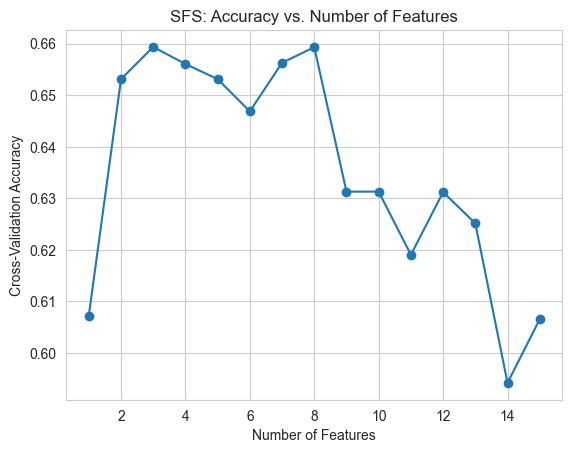

In [126]:
# Forward Selection: Start with no features and add one feature at a time, the one that provides the most significant improvement to the model, until no further improvement is observed.
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize Sequential Feature Selector
sfs = SFS(estimator=rf_classifier,
          k_features='best',
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=5)

# Perform SFS on the training DataFrame
sfs = sfs.fit(X_train_df, y_train)


# Plot the scores
fig, ax = plt.subplots()
# Create a list of the mean scores
mean_scores = [sfs.subsets_[i]['avg_score'] for i in sfs.subsets_]
# Create a list of the number of features
num_features = [len(sfs.subsets_[i]['feature_idx']) for i in sfs.subsets_]
# Plot
ax.plot(num_features, mean_scores, marker='o')
# Set the labels and title
ax.set_xlabel('Number of Features')
ax.set_ylabel('Cross-Validation Accuracy')
ax.set_title('SFS: Accuracy vs. Number of Features')
# Show the plot
plt.show()

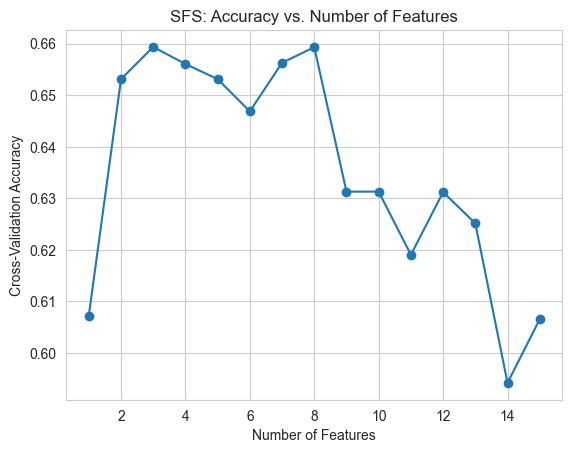

In [101]:
# Backward Elimination: Start with all features and remove one feature at a time, the one that has the least impact on the model performance, until any further removal worsens the performance.
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Initialize the classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize Sequential Feature Selector
sfs = SFS(estimator=rf_classifier,
          k_features='best',  # Use 'best' to select the best number of features
          forward=True,  # Set to True for forward selection
          floating=False,
          scoring='accuracy',
          cv=5)

# Perform SFS on the training data
sfs = sfs.fit(X_train, y_train)

# Plot the scores
fig, ax = plt.subplots()
mean_scores = [sfs.subsets_[i]['avg_score'] for i in range(1, len(sfs.subsets_) + 1)]
num_features = [len(sfs.subsets_[i]['feature_idx']) for i in range(1, len(sfs.subsets_) + 1)]
ax.plot(num_features, mean_scores, marker='o')
ax.set_xlabel('Number of Features')
ax.set_ylabel('Cross-Validation Accuracy')
ax.set_title('SFS: Accuracy vs. Number of Features')
plt.show()

Optimal number of features : 3


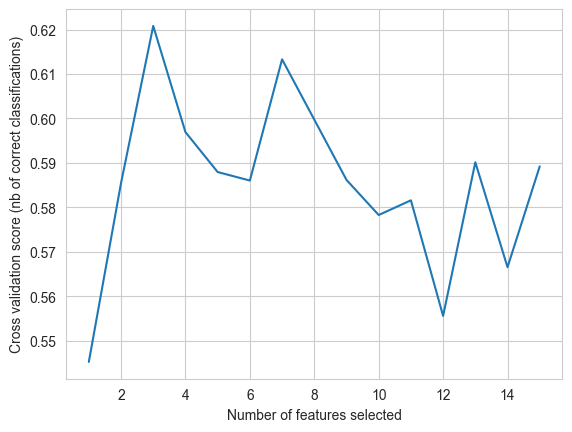

In [123]:
# Feature selection techniques like forward selection, backward elimination, or recursive feature elimination (RFE) can help reduce the number of feature combinations to evaluate. Here’s a brief overview of each method:

# Recursive Feature Elimination (RFE): This is a greedy optimization algorithm that aims to find the best performing feature subset. It repeatedly creates models and keeps aside the best or the worst performing feature at each iteration. It constructs the next model with the left features until all the features are explored. Then it selects the best subset.

# RFE is quite popular and is available in the scikit-learn library. Here's an example of how to implement RFE with a RandomForestClassifier:

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# Initialize the model
rf_classifier = RandomForestClassifier(random_state=42)

# Create the RFE object and compute a cross-validated score
rfecv = RFECV(estimator=rf_classifier, step=1, cv=5, scoring=make_scorer(f1_score))

# Fit RFECV
rfecv.fit(X_train, y_train)

# Print the optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [124]:
# 3, 5, 8 
# You might want to select a threshold to pick features, here we pick the top N
N = 3  # for example, top 3 features
top_n_features = feature_importances_df.head(N)['Feature'].tolist()

# Now you have a list of top N features according to their importance
print(f"Top {N} features by importance:\n{top_n_features}")

Top 3 features by importance:
['Processing Time (seconds)', 'Det_Confidence_Mean', 'Conf_Confidence_Mean']


In [125]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prepare the feature dataframe with only the top 5 features
X_top_features = merged_df[top_n_features]

# Impute missing values using the median for each column
imputer = SimpleImputer(strategy='median')
X_top_imputed = imputer.fit_transform(X_top_features)

# Split the dataset into training set and test set using only the top features
X_train_top, X_test_top, y_train, y_test = train_test_split(
    X_top_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Random Forest classifier
rf_classifier_top = RandomForestClassifier(random_state=42)

# Train the classifier using only the top features
rf_classifier_top.fit(X_train_top, y_train)

# Predict on the test set using the classifier trained on top features
y_pred_top = rf_classifier_top.predict(X_test_top)

# Evaluate the model's performance with only the top features
accuracy_top = accuracy_score(y_test, y_pred_top)
class_report_top = classification_report(y_test, y_pred_top)
conf_matrix_top = confusion_matrix(y_test, y_pred_top)

# Print the results
print(f"Accuracy with top features: {accuracy_top}")
print(f"Classification Report with top features:\n{class_report_top}")
print(f"Confusion Matrix with top features:\n{conf_matrix_top}")

Accuracy with top features: 0.7037037037037037
Classification Report with top features:
              precision    recall  f1-score   support

           0       0.69      0.79      0.73        42
           1       0.73      0.62      0.67        39

    accuracy                           0.70        81
   macro avg       0.71      0.70      0.70        81
weighted avg       0.71      0.70      0.70        81

Confusion Matrix with top features:
[[33  9]
 [15 24]]


In [121]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier_top, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_top, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train a new classifier using the best parameters
best_classifier = grid_search.best_estimator_

# Predict on the test set using the classifier with the best found parameters
y_pred_top = best_classifier.predict(X_test_top)

# Evaluate the model's performance with the best parameters
accuracy_top = accuracy_score(y_test, y_pred_top)
class_report_top = classification_report(y_test, y_pred_top)
conf_matrix_top = confusion_matrix(y_test, y_pred_top)

# Print the results
print(f"Accuracy with the best parameters: {accuracy_top}")
print(f"Classification Report with the best parameters:\n{class_report_top}")
print(f"Confusion Matrix with the best parameters:\n{conf_matrix_top}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 100}
Accuracy with the best parameters: 0.6419753086419753
Classification Report with the best parameters:
              precision    recall  f1-score   support

           0       0.65      0.67      0.66        42
           1       0.63      0.62      0.62        39

    accuracy                           0.64        81
   macro avg       0.64      0.64      0.64        81
weighted avg       0.64      0.64      0.64        81

Confusion Matrix with the best parameters:
[[28 14]
 [15 24]]


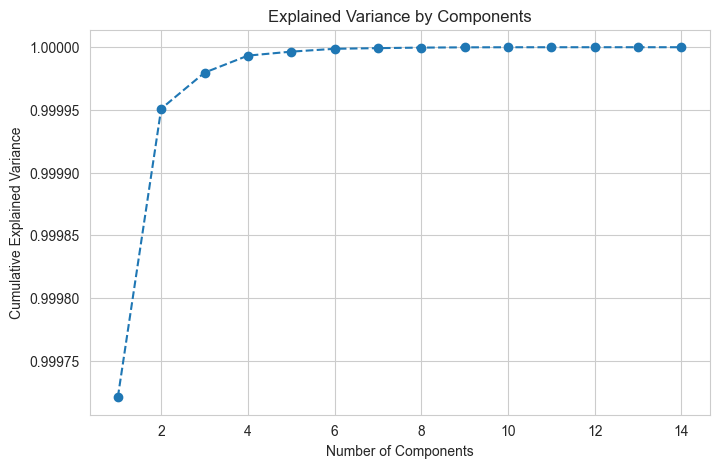

In [186]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Assuming 'merged_df' is your dataframe and 'Label' is your target variable.

# Prepare the feature dataframe (excluding non-feature columns and the target variable)
feature_columns = [
    # 'Detections',
    'Processing Time (seconds)',
    'Density of Detections',
    'Det_Confidence_Mean',
    'Det_Confidence_Median',
    'Det_Confidence_Std',
    'Det_SequenceCount_Mean',
    'Det_SequenceCount_Median',
    'Det_SequenceCount_Std',
    'Conf_Confidence_Mean',
    'Conf_Confidence_Median',
    'Conf_Confidence_Std',
    'Conf_SequenceCount_Mean',
    'Conf_SequenceCount_Median',
    'Conf_SequenceCount_Std'
]

X = merged_df[feature_columns]
y = merged_df['Label'].apply(lambda x: 1 if x == 'SR' else 0)  # Convert labels to binary

# Impute missing values using the median for each column
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Apply PCA
pca = PCA().fit(X_imputed)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

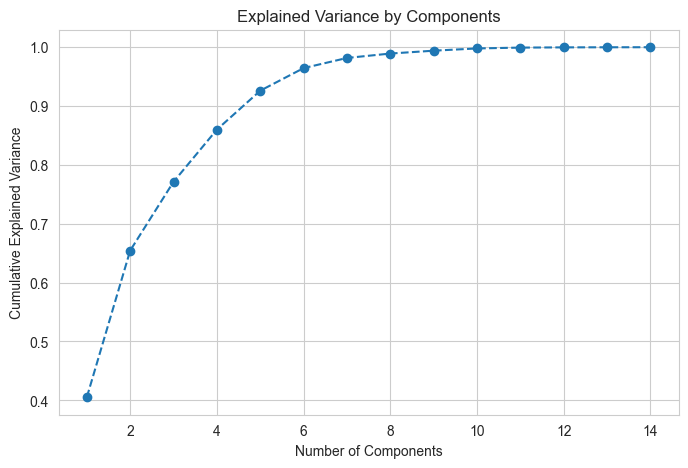

Number of components to retain 95% variance: 6


In [189]:
# Find the best number of principal components to use
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Applying PCA without reducing dimensionality to retain all components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot the cumulative sum of explained variance ratio with the number of components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Choose the number of components that explain the desired amount of variance
# For example, if you want to retain 95% variance, find the number of components that cross this threshold
n_components = sum(pca.explained_variance_ratio_.cumsum() < 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

In [190]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into training and testing sets first
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying PCA
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create a pipeline that standardizes, then runs PCA, then runs the classifier
pipeline = make_pipeline(StandardScaler(), PCA(n_components=6), rf_classifier)

# Fit the pipeline to the training PCA-transformed data
pipeline.fit(X_train_pca, y_train)

# Predict on the test PCA-transformed data
y_pred = pipeline.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{class_report}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.654320987654321
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69        42
           1       0.67      0.56      0.61        39

    accuracy                           0.65        81
   macro avg       0.66      0.65      0.65        81
weighted avg       0.66      0.65      0.65        81

Confusion Matrix:
[[31 11]
 [17 22]]


In [ ]:
I need to see all scatter plot combination between the first four 